# Overview over the EOdal classes
Author: Gregor Perich, 2023

This notebook is to get to know the different classes of the [eodal](https://github.com/EOA-team/eodal) python package better. As you can read in the [Readme](https://github.com/EOA-team/eodal/blob/master/README.md) of `eodal`, there are the following four base classes: 
- `SceneCollection` is a collection of 0 to n Scenes. The scenes are identified by their timestamp or scene identifier (if available).
- `Scene` is s essentially a `RasterCollection` with SceneMetadata assigning the `RasterCollection` a time-stamp and an optional scene identifier.
- `RasterCollection` is a class that contains 0 to n `Band` objects. The bands are identified by their names or alias (if available).
- `Band` is the class for handling single bands. A band is a two-dimensional raster layer (i.e., an two-dimensional array). Each raster cell takes a value. These values could represent color intensity, elevation above mean sea level, or temperature readings, to name just a few examples. A band has a name and an optional alias. Its raster grid cells are geo-referenced meaning each cell can be localized in a spatial reference system.

<img src="../images_for_text/EOdal_Data-Model.jpg" width="900"/>

## Load up some data
In the following code block, we query the [Microsoft Planetary Computer](https://planetarycomputer.microsoft.com/) for some data for a selected bounding box to fill the eodal `Mapper` class with the data. This will take some seconds to grab the data.

In [1]:

import geopandas as gpd
import matplotlib.pyplot as plt
from datetime import datetime
from eodal.config import get_settings
from eodal.core.sensors.sentinel2 import Sentinel2
from eodal.mapper.feature import Feature
from eodal.mapper.filter import Filter
from eodal.mapper.mapper import Mapper, MapperConfigs
from typing import List
from pathlib import Path


# -------------------------- User Inputs ------------------------------
base_dir: Path = Path('../')
data_dir: Path = Path(base_dir.joinpath("data"))
temp_dir: Path = Path(base_dir.joinpath("temp_files"))

Settings = get_settings()
# set to False to use a local data archive
Settings.USE_STAC = True


def preprocess_sentinel2_scenes(
    ds: Sentinel2,
    target_resolution: int,
) -> Sentinel2:
    """
    Resample Sentinel-2 scenes and mask clouds, shadows, and snow
    based on the Scene Classification Layer (SCL).

    NOTE:
        Depending on your needs, the pre-processing function can be
        fully customized using the full power of EOdal and its
        interfacing libraries!

    :param target_resolution:
        spatial target resolution to resample all bands to.
    :returns:
        resampled, cloud-masked Sentinel-2 scene.
    """
    # resample scene
    ds.resample(inplace=True, target_resolution=target_resolution)
    # mask clouds, shadows, and snow
    ds.mask_clouds_and_shadows(inplace=True)
    return ds


# -------------------------- Collection -------------------------------
collection: str = "sentinel2-msi"

# ------------------------- Time Range ---------------------------------
time_start: datetime = datetime(2023, 5, 12)  # year, month, day (incl.)
time_end: datetime = datetime(2023, 6, 12)  # year, month, day (incl.)

# ---------------------- Spatial Feature  ------------------------------
geom: Path = Path(data_dir.joinpath("eschikon_bbox.gpkg"))

# ------------------------- Metadata Filters ---------------------------
metadata_filters: List[Filter] = [
    Filter("cloudy_pixel_percentage", "<", 25),
    Filter("processing_level", "==", "Level-2A"),
]

# %% query the scenes available (no I/O of scenes, this only fetches metadata)
feature = Feature.from_geoseries(gpd.read_file(geom).geometry)
mapper_configs = MapperConfigs(
    collection=collection,
    time_start=time_start,
    time_end=time_end,
    feature=feature,
    metadata_filters=metadata_filters,
)

# write out the mapper configs to yaml file
# get current date in YYYY-MM-DD format
# current_date = datetime.now().strftime("%Y-%m-%d")
# mapper_configs.to_yaml(temp_dir.joinpath(f"{current_date}_mapper_configs.yaml"))

# now, a new Mapper instance is created
mapper = Mapper(mapper_configs)
mapper.query_scenes()

# define which data to get from the scenes
scene_kwargs = {
    "scene_constructor": Sentinel2.from_safe,
    "scene_constructor_kwargs": {"band_selection": ["B02", "B03", "B04", "B08"]},
    "scene_modifier": preprocess_sentinel2_scenes,
    "scene_modifier_kwargs": {"target_resolution": 10},
}

# get scenes into a SceneCollection, this is the I/O step
mapper.load_scenes(scene_kwargs=scene_kwargs)

2023-06-13 10:35:38,228 eodal        INFO     Starting extraction of sentinel2 scenes
2023-06-13 10:35:49,980 eodal        INFO     Finished extraction of sentinel2 scenes


## The mapper class
Now, our [Mapper](https://github.com/EOA-team/eodal/blob/master/eodal/mapper/mapper.py) object contains many different attributes. Let's have a closer look:

In [2]:
mapper

EOdal Mapper
EOdal MapperConfig
------------------
Collection: sentinel2-msi
Time Range: 2023-05-12 00:00:00 - 2023-06-12 00:00:00
Feature:
Name		geometry
Geometry	POLYGON ((8.665850958103075 47.43686554708487, 8.665850958103075 47.46020680051335, 8.712927210431618 47.46020680051335, 8.712927210431618 47.43686554708487, 8.665850958103075 47.43686554708487))
EPSG Code	4326
Attributes	{}
Metadata Filters: [cloudy_pixel_percentage < 25, processing_level == Level-2A]
Data Source: STAC (https://planetarycomputer.microsoft.com/api/stac/v1)

The metadata contains more information on our mapper object, such as the scene_id of the Sentinel-2 scene and info on the cloud coverage (calculated using the [SCL](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/processing-levels/level-2) layer of ESA). Let's take a closer look at the metadata of our mapper:

In [3]:
meta_df = mapper.metadata

# print info
print(f'The metadata is an instance of {type(meta_df)} and has the following shape:')
print('\n')
print(meta_df.shape)
print('\n')
print('and the following columns:')
print('\n')
print(meta_df.columns)

The metadata is an instance of <class 'geopandas.geodataframe.GeoDataFrame'> and has the following shape:


(6, 16)


and the following columns:


Index(['product_uri', 'scene_id', 'spacecraft_name', 'tile_id', 'sensing_date',
       'cloudy_pixel_percentage', 'epsg', 'sensing_time', 'sun_azimuth_angle',
       'sun_zenith_angle', 'geom', 'assets', 'target_epsg', 'mosaicing',
       'real_path', '_duplicated'],
      dtype='object')


We can check the configuration used to get the data as an attribute of our mapper class:

In [4]:
mapper.mapper_configs

EOdal MapperConfig
------------------
Collection: sentinel2-msi
Time Range: 2023-05-12 00:00:00 - 2023-06-12 00:00:00
Feature:
Name		geometry
Geometry	POLYGON ((8.665850958103075 47.43686554708487, 8.665850958103075 47.46020680051335, 8.712927210431618 47.46020680051335, 8.712927210431618 47.43686554708487, 8.665850958103075 47.43686554708487))
EPSG Code	4326
Attributes	{}
Metadata Filters: [cloudy_pixel_percentage < 25, processing_level == Level-2A]
Data Source: STAC (https://planetarycomputer.microsoft.com/api/stac/v1)

We can also save out the configs as a `yaml` file to make queries reproducible. Loading from `yaml` files is also supported.

In [5]:
mapper.mapper_configs.to_yaml(temp_dir.joinpath('mapper_configs.yaml'))

## SceneCollection
Let's take a closer look at the `SceneCollection` object. It contains 6 individual scenes, which can be indexed by their timestamp. We can also see that the individual elements of the `SceneCollection` are of the Type `RasterCollection`.

In [6]:
# write data of the mapper to a variable
scene_coll = mapper.data

# get timestamps
ts_list = scene_coll.timestamps
print(f'The SceneCollection has {len(ts_list)} timestamps.')
print(f'These are: {ts_list}')

# get example timestamp
selected_ts = ts_list[0]

# Select a scene from the SceneCollection
scene_coll[selected_ts]


# if you want, you can loop through the individual scenes like so: 
# for timestamp, scene in scene_coll:
#     print(timestamp)
# 
#     print(scene)

The SceneCollection has 6 timestamps.
These are: ['2023-05-26 10:16:01', '2023-05-29 10:26:01', '2023-05-31 10:15:59', '2023-06-03 10:25:59', '2023-06-05 10:16:01', '2023-06-08 10:26:01']


EOdal RasterCollection
----------------------
# Bands:    5
Band names:    B02, B03, B04, B08, SCL
Band aliases:    blue, green, red, nir_1, scl

We can call the `get_feature_timeseries` method on the `SceneCollection` to extract summarized information on a supplied AOI. Here, we summarize information on a small example field within the main AOI for all timestamps in the `SceneCollection`. This is super useful for time series analysis. 

<Axes: title={'center': 'red, green, blue'}, xlabel='X [m] (EPSG:32632)', ylabel='Y [m] (EPSG:32632)'>

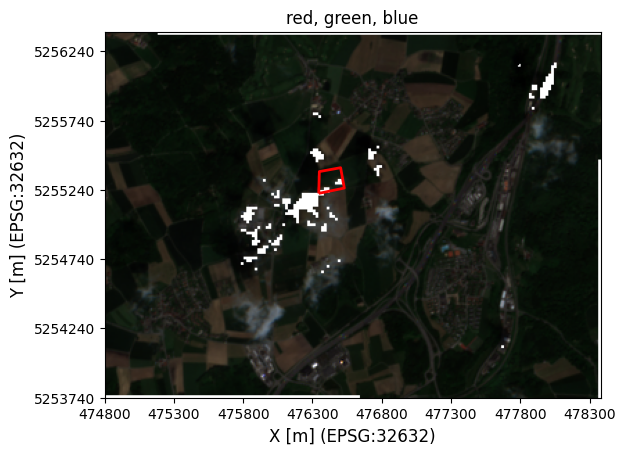

In [7]:
# read in small field AOI
field_gdf = gpd.read_file(data_dir.joinpath("example_field.gpkg"))
field_gdf = field_gdf.to_crs("epsg:32632")

# visualize the field for our selected scene
scene_coll[selected_ts].plot_multiple_bands(["red", "green", "blue"])
field_gdf.plot(facecolor="none", edgecolor="red", linewidth=2, ax=plt.gca())

In [8]:
# extract the time series of the selected AOI, default are [min, mean, max, std and count]
field_values_df = scene_coll.get_feature_timeseries(field_gdf)

print(f'There are {field_values_df.shape[0]} entries in the df with {field_values_df.acquisition_time.nunique()} unique timestamps')

field_values_df.head()

There are 30 entries in the df with 6 unique timestamps


min      mean       std     max  count   
0  0.1239  0.154272  0.025982  0.2670  218.0  \
1  0.1445  0.188258  0.025196  0.3000  218.0   
2  0.1223  0.160796  0.031796  0.2910  218.0   
3  0.3752  0.578098  0.064087  0.6612  218.0   
4  4.0000  4.509728  1.160682  8.0000  257.0   

                                            geometry band_name   
0  POLYGON ((476345.276 5255214.841, 476349.494 5...       B02  \
1  POLYGON ((476345.276 5255214.841, 476349.494 5...       B03   
2  POLYGON ((476345.276 5255214.841, 476349.494 5...       B04   
3  POLYGON ((476345.276 5255214.841, 476349.494 5...       B08   
4  POLYGON ((476345.276 5255214.841, 476349.494 5...       SCL   

     acquisition_time  
0 2023-05-26 10:16:01  
1 2023-05-26 10:16:01  
2 2023-05-26 10:16:01  
3 2023-05-26 10:16:01  
4 2023-05-26 10:16:01

We can plot all scenes in the `SceneCollection` at once

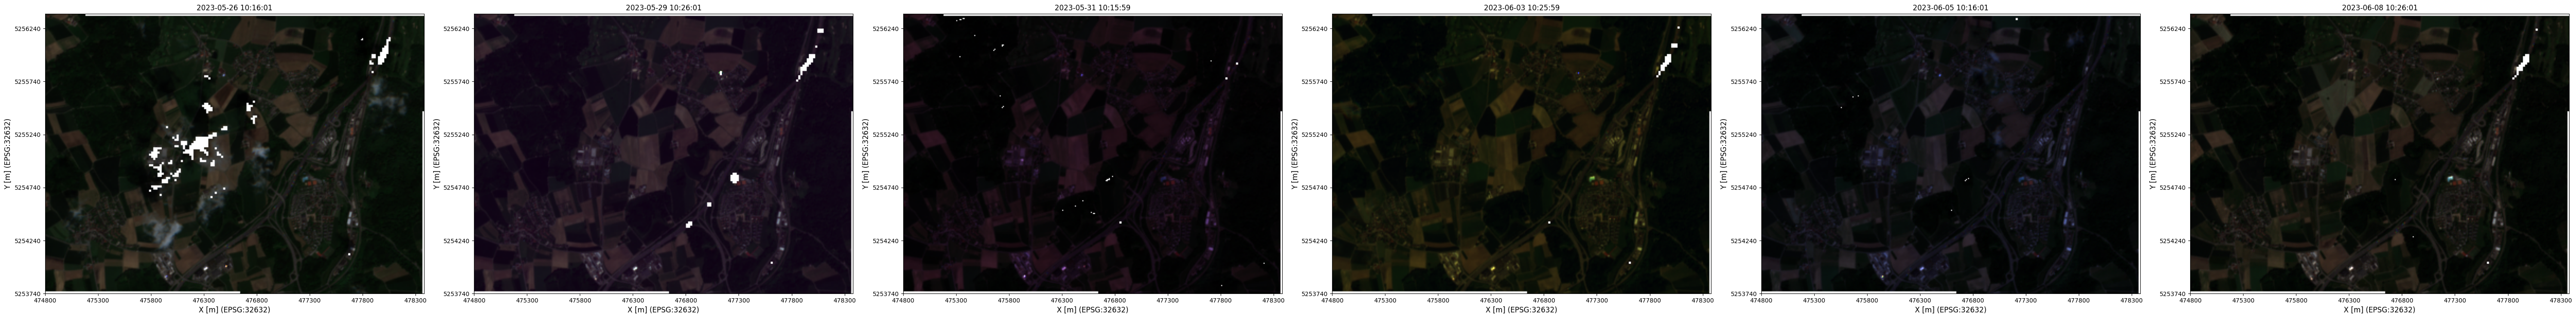

In [9]:
# plot all scenes
fig = scene_coll.plot(band_selection=["red", "green", "blue"], figsize=(60, 20))
fig.tight_layout()

We can calculate spectral indices, such as the [NDVI](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) on all scenes of the `SceneCollection`:

/home/gperich/python_venvs/eodal_dev/lib/python3.10/site-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


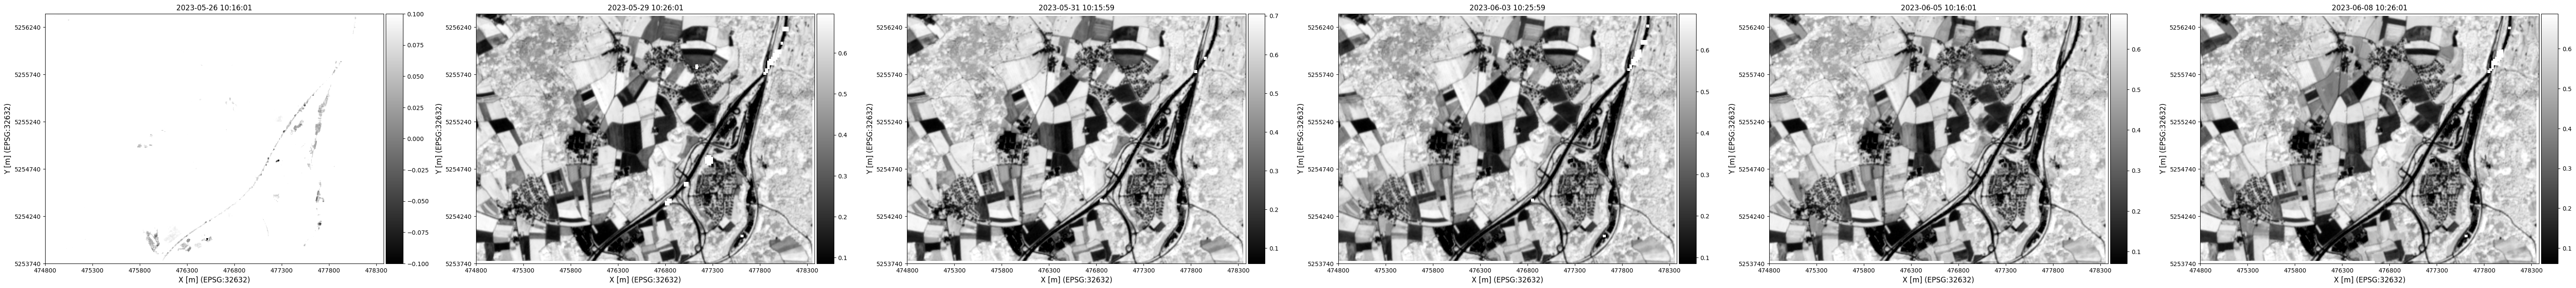

In [10]:
# calculate NDVI on all scenes
for __, scene in scene_coll:
    scene.calc_si("NDVI", inplace=True) # add NDVI to scene without copying

# plot the NDVI
fig = scene_coll.plot(band_selection="NDVI", figsize=(60, 20))
fig.tight_layout()

We can write the `SceneCollection` to a `pickle` object to store it permanently on the disk. Loading from the `pickle` object is also supported. 

**Caution:** Depending on your AOI, time range and spatial resolution, this may result in really large `pickle` files!

In [11]:
# write the SceneCollection to a pickle file
# This example is ca. 21 MB large

fpath = temp_dir.joinpath('SceneCollection.pkl')
with open(fpath, 'wb+') as dst:
    dst.write(scene_coll.to_pickle())

# load the file again

# from eodal.core.scene import SceneCollection
# scene_coll = SceneCollection.from_pickle(fpath)

## RasterCollection
Often, you'll want to work with the `SceneCollection`, as it allows operations on all stored (0 to N scenes) directly. If we want to work on a specific scene, however, we'll have to interact with the `RasterCollection` object of that scene. 

Now, let's select a scene crom the `SceneCollection` using a timestamp. We've already seen above that the individual scenes in the `SceneCollection` are stored as a `RasterCollection` [objects](https://github.com/EOA-team/eodal/blob/master/eodal/core/raster.py). The object has the `bands` defined in the `scene_kwargs` above (here bands "blue", "green", "red" and "nir_1" plus the SCL layer, which comes as part of the Sentinel-2 class).

In [12]:
# select a scene
scene = scene_coll[selected_ts]

print(scene)
print('\n')
print(f'The RasterCollection is of the type: {type(scene)}')

EOdal RasterCollection
----------------------
# Bands:    6
Band names:    B02, B03, B04, B08, SCL, NDVI
Band aliases:    blue, green, red, nir_1, scl, ndvi


The RasterCollection is of the type: <class 'eodal.core.sensors.sentinel2.Sentinel2'>


We can easily plot multiple bands or only selected bands:

Text(0.5, 1.0, 'NDVI')

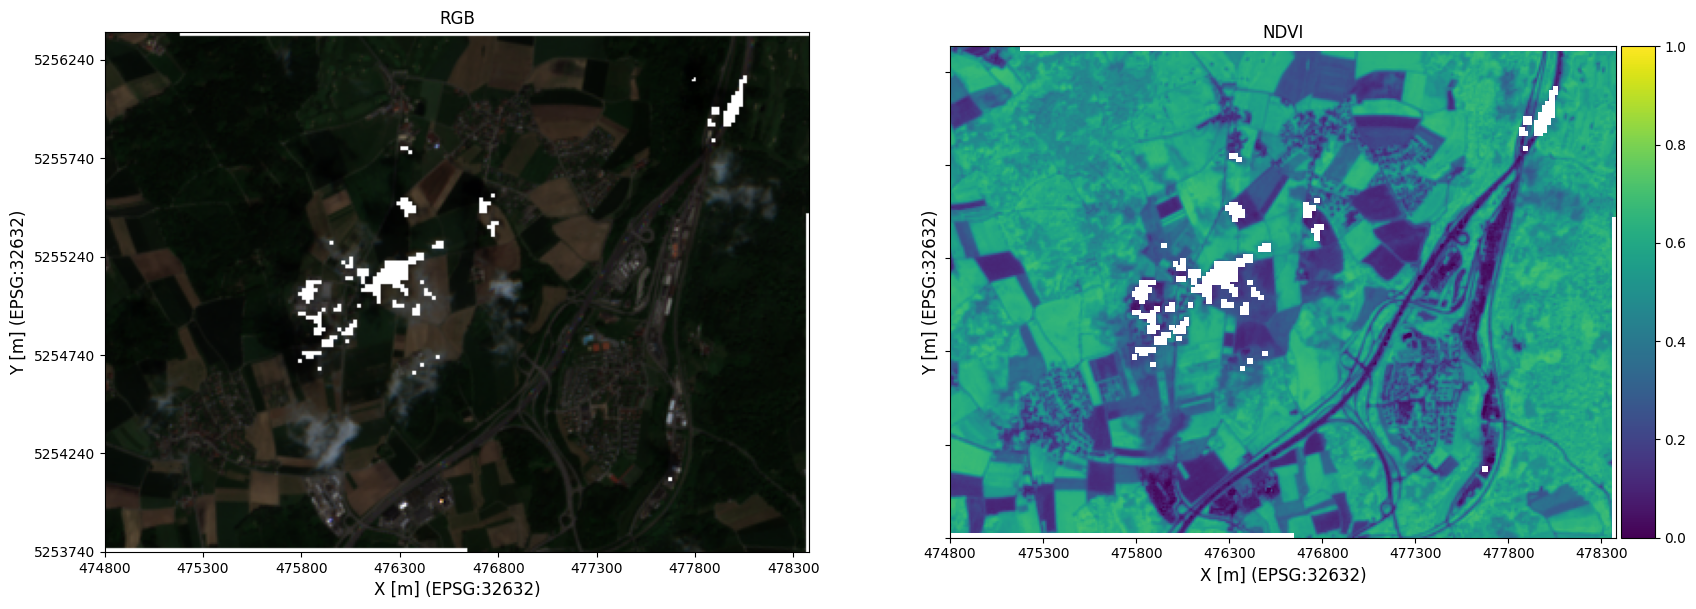

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharey=True)
scene.plot_multiple_bands(["red", "green", "blue"], ax=axs[0])
axs[0].set_title("RGB")
scene.plot_band("NDVI", colormap="viridis", vmin=0, vmax=1, ax=axs[1])
axs[1].set_title("NDVI")
# plt.tight_layout()

As we can see, there are some masked out pixels. These originate from clouds:

In [14]:
clouds_percent = scene.get_cloudy_pixel_percentage()
print(f'The scene has {clouds_percent:.2f}% cloudy pixels.')

The scene has 1.04% cloudy pixels.


We can access the values of the individual bands either from the scene directly, or filter using the band names or band aliases. This returns the values as a `numpy` masked array, ready to be used for further analysis. Note how the shape of the `allband_array` corresponds to the BANDID, Y-RESOLUTION, X-RESOLUTION. The BANDID can be matched using the `band_names` method. 

In [15]:
# get values of all bands from the scene directly
allband_array = scene.get_values()
print(f'Shape of the array containing all bands is: {allband_array.shape}')
print('\n')
print(f'Bands are {scene.band_names}')
print('\n')
print(f'The type of the individual bands is {type(allband_array)}')


band2 = scene.get_band('B02').values
# print(f'The type of the individual bands is {type(band2)}')

Shape of the array containing all bands is: (6, 264, 358)


Bands are ['B02', 'B03', 'B04', 'B08', 'SCL', 'NDVI']


The type of the individual bands is <class 'numpy.ma.core.MaskedArray'>


In [16]:
# get values of a single band from the scene
band2 = scene.get_band('B02').values

# equivalent to using the band alias
blueband = scene.get_band('blue').values

import numpy as np
np.array_equal(band2, blueband)

True